In [1]:
from __future__ import print_function

import numpy as np
import math,time
import torch
import gpytorch

from matplotlib import cm, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys, os, json, time

%matplotlib inline

In [2]:
# 500 random locations in [(-10,-10), (10, 10)] square
# and probabilities to be associated with these locations
xylim = 10
num_points = 5000
std_max = 0.1

locs = ( np.random.rand(num_points, 2) * 2*xylim ) - xylim
# locs = np.vstack( ( np.linspace( -xylim, xylim, num_points ), \
#                     np.linspace( -xylim, xylim, num_points ) ) ).transpose()
locs.sort(axis=0)
locs = np.asarray(locs, dtype=np.float32)

probs = np.sin(locs[:,1]) #np.random.rand(num_points,)

prob_std = ( np.random.rand(num_points,) * 2*std_max ) - std_max
# prob_std = std_max * np.ones_like(probs)

probs_new = (probs * (1-std_max)) + prob_std
probs_new = np.asarray(probs_new, dtype=np.float32)

# overflow = probs_new >= 0.99
# probs_new[overflow] = 0.99
# prob_std[overflow] = 0.99 - probs[overflow]

# overflow = probs_new <= 0
# probs_new[overflow] = 0.01
# prob_std[overflow] = 0.01 - probs[overflow]

prob_var = np.asarray(prob_std**2, dtype=np.float32)

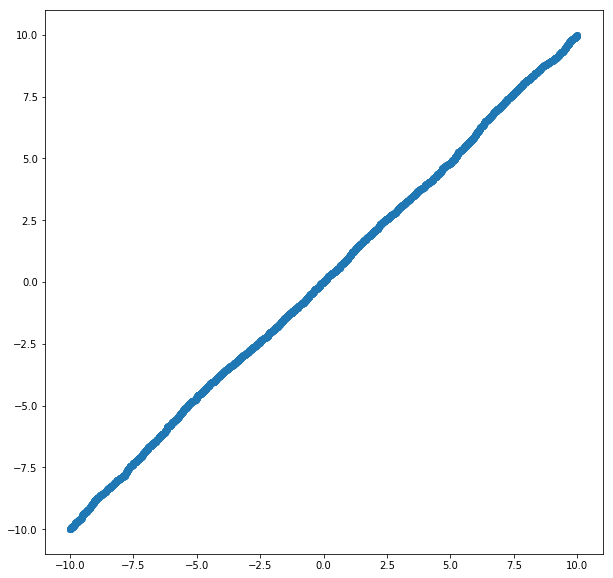

In [3]:
fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection='3d')
ax = fig.gca()
ax.scatter( locs[:, 1], locs[:, 0] ) #, c=probs_new, cmap='cool' )

In [4]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean().cuda()
            self.covar_module = gpytorch.kernels.RBFKernel().cuda()
#             self.covar_module = gpytorch.kernels.PeriodicKernel().cuda()

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
train_x = torch.from_numpy(locs).cuda()
train_y = torch.from_numpy(probs_new).cuda()
train_y_var = torch.from_numpy(prob_var).cuda()

log_noise_model = GPRegressionModel(
    train_x,
    train_y_var,
    gpytorch.likelihoods.GaussianLikelihood().cuda()
)

likelihood = gpytorch.likelihoods._GaussianLikelihoodBase(
    noise_covar=gpytorch.likelihoods.HeteroskedasticNoise(log_noise_model)
).cuda()
model = GPRegressionModel( train_x, train_y, likelihood ).cuda()

In [6]:
model

GPRegressionModel(
  (likelihood): _GaussianLikelihoodBase(
    (noise_covar): HeteroskedasticNoise(
      (noise_model): GPRegressionModel(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise()
        )
        (mean_module): ConstantMean()
        (covar_module): RBFKernel()
      )
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel()
)

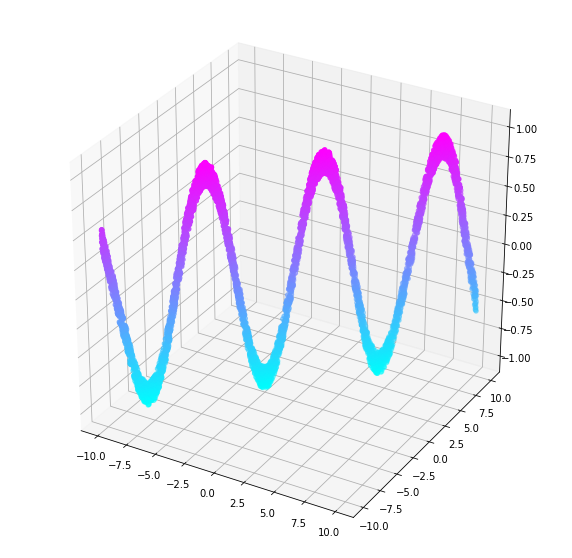

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter( locs[:, 1], locs[:, 0], probs_new, c=probs_new, cmap='cool' )

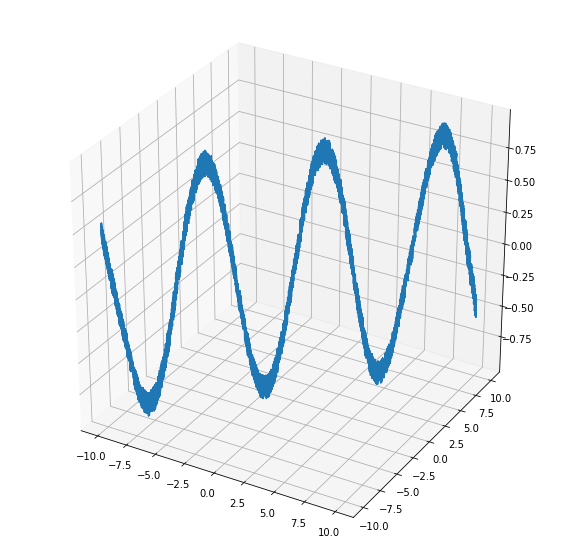

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot( locs[:, 1], locs[:, 0], probs_new )

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 75
tic = time.time()
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y, train_x)
    loss.backward()
    if (i+1) % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()
    
print(f"wall time: {time.time() - tic:.2f} sec")

Iter 10/75 - Loss: 0.488
Iter 20/75 - Loss: -0.005
Iter 30/75 - Loss: -0.484
Iter 40/75 - Loss: -0.918
Iter 50/75 - Loss: -1.267
Iter 60/75 - Loss: -1.518
Iter 70/75 - Loss: -1.720
wall time: 46.14 sec


In [10]:
model.eval()
likelihood.eval()

test_xylim = 15
test_num_points = 5000

test_locs = np.vstack( (  np.linspace(-test_xylim, test_xylim, test_num_points), \
                          np.linspace(test_xylim, -test_xylim, test_num_points) ) ).transpose()
test_locs.sort(axis=0)
test_locs = np.asarray(test_locs, dtype=np.float32)

with torch.no_grad(), gpytorch.fast_pred_var():
    ctime = time.time()
    test_x = torch.from_numpy(test_locs).cuda()
    post_f = model(test_x)
    post_obs = likelihood(post_f, test_x)
    
    print('Execution time: ', time.time()-ctime )

/home/bgavin/anaconda3/envs/sar/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:177: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


Execution time:  3.0697743892669678


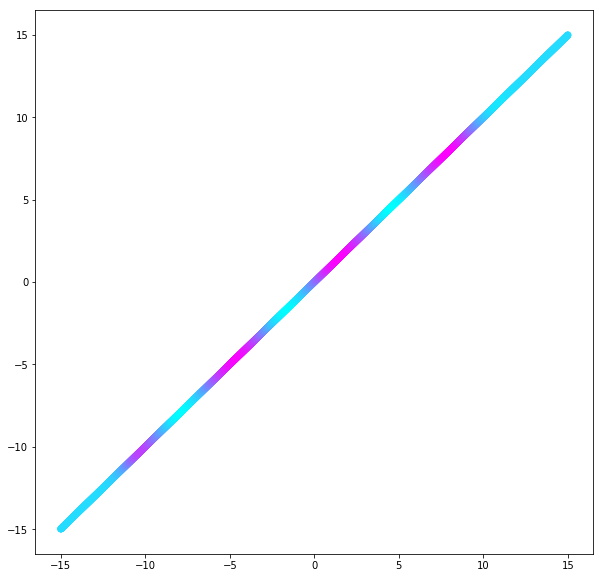

In [11]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()

    lower_f, upper_f = post_f.confidence_region()
    lower_f, upper_f = lower_f.cpu(), upper_f.cpu()
    
    lower_obs, upper_obs = post_obs.confidence_region()
    lower_obs, upper_obs = lower_obs.cpu(), upper_obs.cpu()

    post_f__mean_cpu = post_f.mean.cpu().numpy()
    ax.scatter( test_locs[:, 1], test_locs[:, 0], c=post_f__mean_cpu, cmap='cool' )

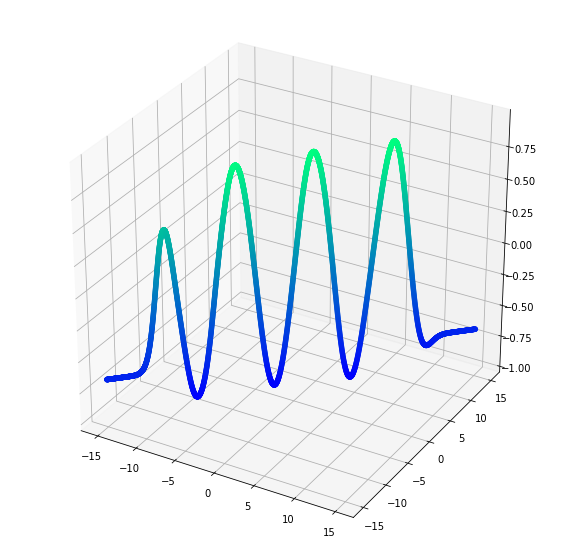

In [12]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca(projection='3d')
    
    ax.scatter( test_locs[:, 1], test_locs[:, 0], post_f__mean_cpu, c=post_f__mean_cpu, cmap='winter' )

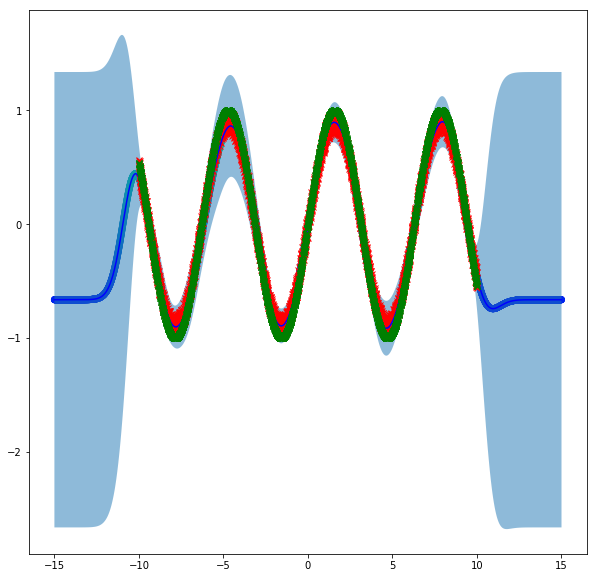

In [13]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    ax.scatter( test_locs[:, 1], post_f__mean_cpu, c=post_f__mean_cpu, cmap='winter' )
    ax.plot(locs[:, 1], probs_new, 'rx')

    ax.plot( test_locs[:, 1], post_f__mean_cpu, 'b')
    
    ax.fill_between(test_locs[:, 1], lower_f.numpy(), upper_f.numpy(), alpha=0.5)#, color='k')
#     ax.fill_between(test_locs[:, 1], lower_obs.numpy(), upper_obs.numpy(), alpha=0.25, color='r')
    
    ax.plot( locs[:, 1], probs, 'gx')
#     ax.set_ylim([-3, 3])
#     ax.legend(['Observed Data', 'Mean', 'Confidence (f)', 'Confidence (obs)'])

In [14]:
print(post_f, '\n', post_obs)

MultivariateNormal(loc: torch.Size([5000])) 
 MultivariateNormal(loc: torch.Size([5000]))
